In [1]:
#!/usr/bin/env python

# # Imports

# Numerical and data processing libraries
import numpy as np
import pandas as pd
import pickle

from libs.paths import results_folder, data_folder
from libs import feature_extraction_lib as ftelib
from libs import preprocessing_lib as pplib
from libs import cti_interval_lib as ctilib
from libs.label_mappings import get_label_meaning
import matplotlib.pyplot as plt

In [2]:

# Input files
signal_x = 'ECG'  # First signal
signal_y = 'PCG'  # Second signal (can be the same as signal_x)
label_x = 2       # Label from first signal
label_y = 2       # Label from second signal
fs_x = 500
fs_y = 3000

signals = {signal_x: [label_x, fs_x], signal_y: [label_y, fs_y]}

name_interval, name_x, name_y = get_label_meaning(signal_x, signal_y, label_x, label_y)
print(name_interval)

# # %% ULSGE Dataset results

# # Import Original

data_file_path = data_folder / "std_chvnge_df.pkl"
df = pd.read_pickle(data_file_path)

# Drop empty columns
df = df.drop(index=[491, 503])
df = df.reset_index(drop=True)

# Resample them to 50 Hz
# Optimize the processing of the dataset
for signal, arr in signals.items():
    fs = arr[1]
    df[f'{signal} Signal'] = df[f'{signal} Signal'].apply(
        lambda data: pplib.z_score_standardization(data))    
    df[f'{signal} Signal'] = df[f'{signal} Signal'].apply(
        lambda data: pplib.downsample(data, fs, 50))

# Load predictions dynamically
predictions = {}

for signal in signals.keys():
    results_file_path = results_folder / f"{signal}_unet_predictions.pkl"
    with open(results_file_path, 'rb') as f:
        predictions[signal] = pickle.load(f)

print(f"Loaded predictions successfully: {type(predictions)}")

QS2
Loaded predictions successfully: <class 'dict'>


In [3]:
# Load the data from pickle
with open(results_folder / "combined_processed_predictions.pkl", "rb") as f:
    all_data = pickle.load(f)

# Initialize an empty dictionary to hold the processed predictions
processed_predictions = {}

# Extract the max temporal predictions for each signal and store them in processed_predictions
for signal in signals:
    processed_predictions[signal] = all_data[signal]["sequence"]

# Convert the processed_predictions into a Pandas DataFrame
# We assume each signal's predictions are arrays of the same length
processed_predictions_df = pd.DataFrame({signal: pd.Series(processed_predictions[signal]) for signal in signals})

# You can now work with the DataFrame
print(processed_predictions_df.head())

                                                 ECG  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                 PCG  
0  [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  
1  [3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...  
2  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...  
3  [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...  
4  [3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 1, ...  


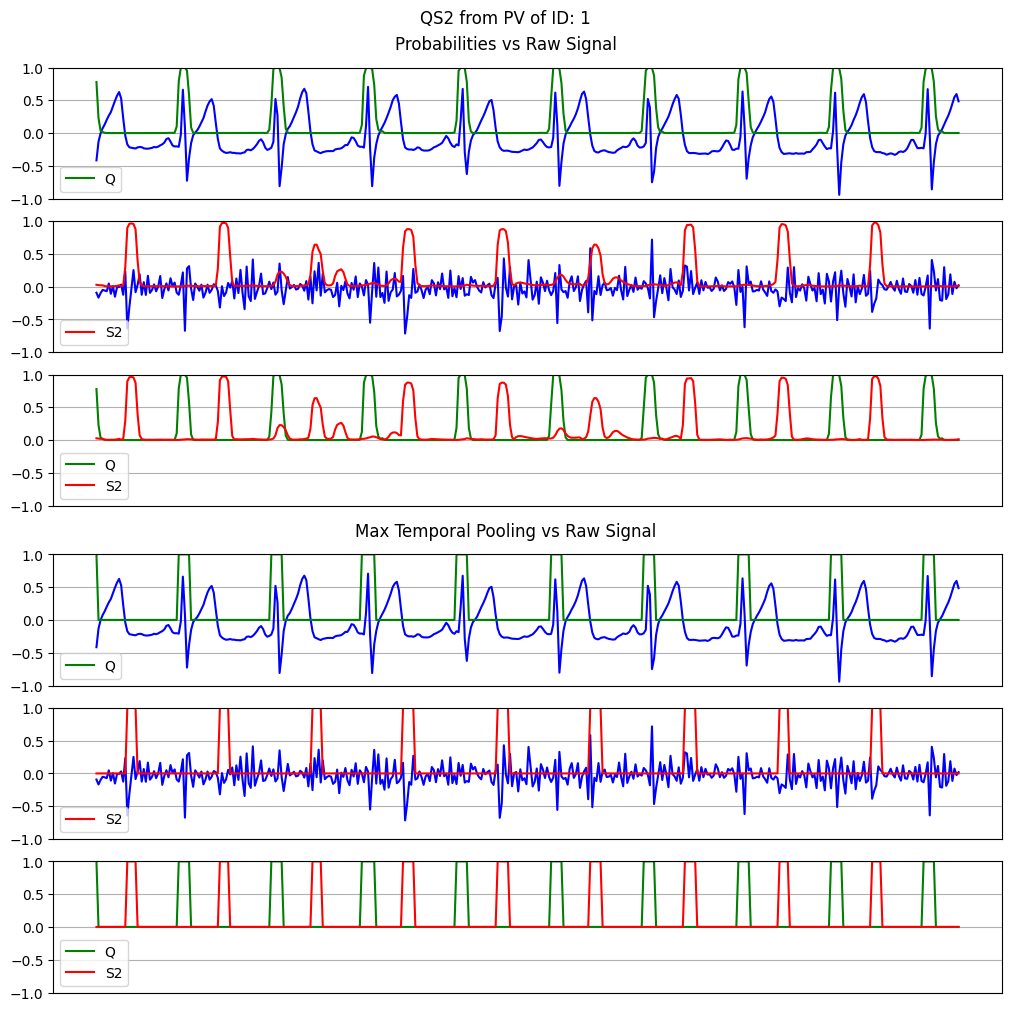

In [5]:
i = 2
ID = df['ID'].iloc[i]
AP = df['Auscultation Point'].iloc[i]
# Create main figure
fig = plt.figure(layout='constrained', figsize=(10, 10))
fig.suptitle(f'{name_interval} from {AP} of ID: {ID}')

subfigs = fig.subfigures(2, 1, hspace=0)

top = subfigs[0].subplots(3, 1, sharex=True, sharey=True)
subfigs[0].suptitle('Probabilities vs Raw Signal')
top[0].plot(pplib.min_max_norm2(df[f'{signal_x} Signal'].iloc[i])[380:800], color='blue')
top[0].plot(predictions[signal_x][i][380:800, label_x], label=name_x, color='green')
top[0].set_xticks([])
top[0].set_ylim(-1, 1)
top[0].legend(loc=3)
top[0].grid()

top[1].plot(pplib.min_max_norm2(df[f'{signal_y} Signal'].iloc[i])[380:800], color='blue')
top[1].plot(predictions[signal_y][i][380:800, label_y], label=name_y, color='red')
top[1].set_xticks([])
top[1].set_ylim(-1, 1)
top[1].legend(loc=3)
top[1].grid()

top[2].plot(predictions[signal_x][i][380:800, label_x], label=name_x,  color='green')
top[2].plot(predictions[signal_y][i][380:800, label_y], label=name_y, color='red')
top[2].set_xticks([])
top[2].set_ylim(-1, 1)
top[2].legend(loc=3)
top[2].grid()

bot = subfigs[1].subplots(3, 1, sharex=True, sharey=True)
subfigs[1].suptitle('Max Temporal Pooling vs Raw Signal')
bot[0].plot(pplib.min_max_norm2(df[f'{signal_x} Signal'].iloc[i])[380:800], color='blue')
bot[0].plot(np.where(processed_predictions[f'{signal_x}'][i][380:800] == label_x,1,0), label=name_x,color='green')
bot[0].set_xticks([])
bot[0].set_ylim(-1, 1)
bot[0].legend(loc=3)
bot[0].grid()

bot[1].plot(pplib.min_max_norm2(df[f'{signal_y} Signal'].iloc[i])[380:800], color='blue')
bot[1].plot(np.where(processed_predictions[f'{signal_y}'][i][380:800] == label_y,1,0), label=name_y,color='red')
bot[1].set_xticks([])
bot[1].set_ylim(-1, 1)
bot[1].legend(loc=3)
bot[1].grid()

bot[2].plot(np.where(processed_predictions[f'{signal_x}'][i][380:800] == label_x,1,0), label=name_x,color='green')
bot[2].plot(np.where(processed_predictions[f'{signal_y}'][i][380:800] == label_y,1,0), label=name_y,color='red')
bot[2].set_xticks([])
bot[2].set_ylim(-1, 1)
bot[2].legend(loc=3)
bot[2].grid()

# Save the plot
plt.savefig(f"{name_interval}_{i}_Estimates.png")  # Save as PNG

plt.show()